## script for data acquisition

#### Content:
- city boundaries of Graz
- street network of Graz and surrounding area within 1000m
- POIs in Graz and surrounding area withing 1000m: 
  public transport stations, supermarkets, green spaces, pharmacies, doctors
- population of Graz for the year 2020 (100x100m grid)
- buildings of Graz
- residential areas of Graz

#### Data sources:
- City Boundaries:
OpenStreetMap contributors (2025). OpenStreetMap database (city & District Boundaries). Retrieved December 22, 2025, from https://www.openstreetmap.org
- Street Network:
OpenStreetMap contributors (2025). OpenStreetMap database (Street Network). Retrieved December 23, 2025, from https://www.openstreetmap.org
- POIs:
OpenStreetMap contributors. (2025). OpenStreetMap database (POI). Retrieved December 25, 2025, from https://www.openstreetmap.org
- Population 2020 (100m grid):
Pesaresi, M., Schiavina, M., Politis, P., Freire, S., Krasnodębska, K., Uhl, J. H., Carioli, A., Corbane, C., Dijkstra, L., Florio, P., Friedrich, H. K., Gao, J., Leyk, S., Lu, L., Maffenini, L., Mari-Rivero, I., Melchiorri, M., Syrris, V., Van Den Hoek, J., & Kemper, T. (2023). GHS-POP R2023A — GHS population grid multitemporal (1975–2030). Dataset: GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C20. European Commission, Joint Research Centre. https://doi.org/10.2905/2FF68A52-5B5B-4A22-8F40-C41DA8332CFE. Available under: https://human-settlement.emergency.copernicus.eu/download.php?ds=pop
- Buildings:
OpenStreetMap contributors (2025). OpenStreetMap database (Buildings). Retrieved December 26, 2025, from https://www.openstreetmap.org
- Residential Areas:
OpenStreetMap contributors (2025). OpenStreetMap database (Residential). Retrieved December 26, 2025, from https://www.openstreetmap.org

In [1]:
!pip install osmnx rasterio

In [9]:
!pip install pyarrow

   ---------------------------------------- 0.0/28.0 MB ? eta -:--:--
   - -------------------------------------- 1.0/28.0 MB 4.8 MB/s eta 0:00:06
   --- ------------------------------------ 2.4/28.0 MB 5.6 MB/s eta 0:00:05
   ----- ---------------------------------- 3.7/28.0 MB 5.9 MB/s eta 0:00:05
   ------- -------------------------------- 5.0/28.0 MB 6.0 MB/s eta 0:00:04
   -------- ------------------------------- 6.3/28.0 MB 6.1 MB/s eta 0:00:04
   ---------- ----------------------------- 7.3/28.0 MB 5.9 MB/s eta 0:00:04
   ------------ --------------------------- 8.7/28.0 MB 5.9 MB/s eta 0:00:04
   -------------- ------------------------- 10.0/28.0 MB 5.8 MB/s eta 0:00:04
   ---------------- ----------------------- 11.3/28.0 MB 5.8 MB/s eta 0:00:03
   ----------------- ---------------------- 12.6/28.0 MB 5.9 MB/s eta 0:00:03
   ------------------- -------------------- 13.9/28.0 MB 5.9 MB/s eta 0:00:03
   ---------------------- ----------------- 15.5/28.0 MB 6.0 MB/s eta 0:00:03
 

In [53]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
import numpy as np
from pathlib import Path
import networkx as nx
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon, box
from collections import defaultdict
import pyarrow

In [3]:
from sklearn.cluster import DBSCAN

Define paths and project variables

In [4]:
BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"

POP_RAW_PATH = DATA_DIR / "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C20.tif"
POP_GRAZ_PATH = DATA_DIR / "graz_population.tif"
GRAPH_PATH = DATA_DIR / "graz_street_network_buffer1km.graphml" # Change to DATA_DIR
EDGE_PATH = DATA_DIR / "graz_street_network_edges.parquet"
NODE_PATH = DATA_DIR / "graz_street_network_nodes.parquet"
POI_PATH = DATA_DIR / "graz_pois.parquet"
GREEN_SPACES_PATH = DATA_DIR / "graz_green_spaces_raw.parquet"
ACCESS_POINTS_PATH = DATA_DIR / "graz_green_access_points.parquet"
RESIDENTIAL_PATH = DATA_DIR / "graz_residential_areas.parquet"
BUILDINGS_PATH = DATA_DIR / "graz_buildings.parquet"
POI_ALL_PATH = DATA_DIR / "graz_pois_all.parquet"
POI_ALL_POINTS_PATH = DATA_DIR / "graz_pois_all_points.parquet"


project_crs = 31256  # MGI / Austria GK East

### Data integration

##### Load city boundary of Graz

In [5]:
# define place name
place_name:str = "Graz, Austria"

# get the boundary polygon of Graz
gdf_graz = ox.geocode_to_gdf(place_name)

# change CRS to EPSG: 31256
gdf_graz = gdf_graz.to_crs(epsg=project_crs)

##### Load district boundaries of Graz

In [6]:
# get districts of Graz
gdf_districts = ox.features_from_place(place_name, tags={'admin_level': '9'})

# filter to get only polygons and reproject
gdf_districts = gdf_districts[gdf_districts.geometry.type.isin(['Polygon', 'MultiPolygon'])]
gdf_districts = gdf_districts.to_crs(epsg=31256)

# drop all columns except 'name' and 'geometry'
gdf_districts = gdf_districts[['name', 'geometry']]

##### Load street network of Graz and 1000m beyond

In [11]:
# buffer (1000m) boundary of Graz
buffered_poly_31256 = gdf_graz.geometry.iloc[0].buffer(1000)

# reproject buffer for osmnx (WGS84)
buffered_poly_wgs84 = (
    gpd.GeoSeries([buffered_poly_31256], crs="EPSG:31256")
    .to_crs("EPSG:4326")
    .iloc[0]
)

try:
    edges = gpd.read_parquet(EDGE_PATH)
    nodes = gpd.read_parquet(NODE_PATH)
    network_graz = ox.load_graphml(GRAPH_PATH)
except:
    # load street network in buffered polygon, network_type = 'walk'

    # TODO: network type walk or all?
    
    G = ox.graph_from_polygon(
        buffered_poly_wgs84,
        network_type="walk",
        simplify=True
    )

    # reproject to project crs
    G = ox.project_graph(G, to_crs="EPSG:31256")
    ox.save_graphml(G, filepath=GRAPH_PATH)
    network_graz = ox.load_graphml(GRAPH_PATH)

    # convert street network graphs into two GeoDataFrames
    nodes_raw, edges_raw = ox.graph_to_gdfs(G, nodes=True, edges=True)

    # remove list columns
    def drop_list_columns(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
        list_cols = [
            c for c in gdf.columns
            if c != "geometry" and gdf[c].apply(lambda x: isinstance(x, list)).any()
        ]
        return gdf.drop(columns=list_cols)

    edges_clean = drop_list_columns(edges_raw)
    nodes_clean = drop_list_columns(nodes_raw)

    # save as GeoParquet
    edges_clean.to_parquet(EDGE_PATH, index=False)
    nodes_clean.to_parquet(NODE_PATH, index=False)
    edges = gpd.read_parquet(EDGE_PATH)
    nodes = gpd.read_parquet(NODE_PATH)

Quick overview map: Plot nodes, edges and boundary of Graz

<Axes: >

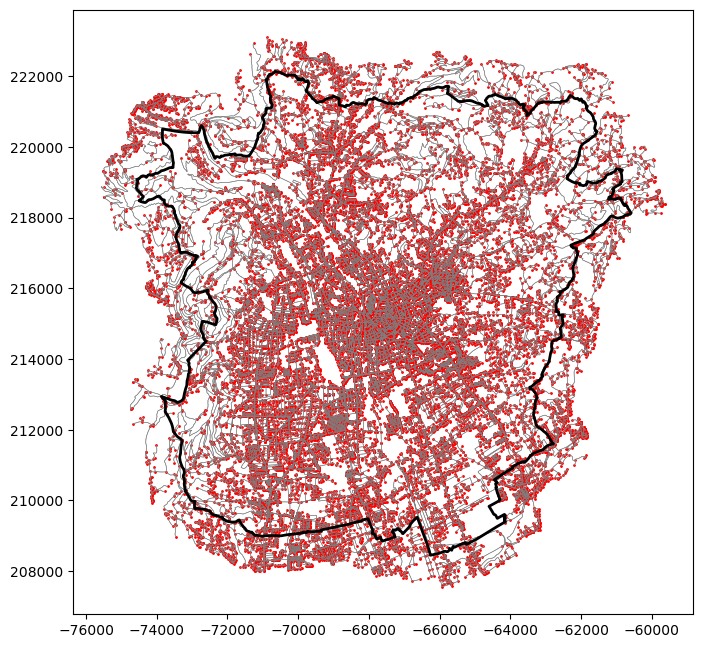

In [12]:
ax = edges.plot(figsize=(8, 8), linewidth=0.4, color="grey")
nodes.plot(ax=ax, markersize=1, color="red")

gdf_graz.boundary.plot(ax=ax, edgecolor="black", linewidth=2)

##### POIs in Graz and surrounding area withing 1000m: public transport stations, supermarkets, green spaces, pharmacies, doctors


Define POI tags

In [13]:
tags = {
    # public transport stations & stops
    "highway": ["platform", "bus_stop"],
    "public_transport": ["platform", "stop_position"],
    "railway": ["tram_stop"],

    # supermarkets
    "shop": ["supermarket", "chemist"],

    # pharmacies & doctors
    "amenity": ["doctors", "pharmacy"],
}

tags_green_spaces = {
    # green spaces
    "leisure": ["park", "garden", "recreation_ground"],
    "landuse": ["forest", "recreation_ground", "cemetery"],
    "natural": ["wood"],
    "amenity": ["park", "playground", "graveyard"],
}

Load POIs from OSM

In [14]:
pois = ox.features_from_polygon(buffered_poly_wgs84, tags=tags) # osmnx sends a request to the Overpass API
pois = pois.to_crs("EPSG:31256")
pois = pois.to_parquet(POI_PATH, index=False)
pois = gpd.read_parquet(POI_PATH)

Exclude invalid green spaces and calculate access points

In [15]:
# Query raw green spaces once
green_spaces_raw = ox.features_from_polygon(buffered_poly_wgs84, tags=tags_green_spaces)
green_spaces_raw = green_spaces_raw.to_crs("EPSG:31256")

# Save as GeoParquet
green_spaces_raw.to_parquet(GREEN_SPACES_PATH, index=False)
green_spaces = gpd.read_parquet(GREEN_SPACES_PATH)

In [16]:
# Drop private gardens without name
green_spaces = green_spaces[~((green_spaces["leisure"] == "garden") & (green_spaces["name"].isna()))]

#exclude public green spaces that are marked as 'no' or 'private' access
green_spaces = green_spaces[green_spaces['access'].isna() | green_spaces['access'].isin(['yes', 'permissive'])]

# Exclude green spaces smaller than 1 ha
green_spaces = green_spaces[green_spaces.geometry.area >= 10000]

# Exclude green spaces within 50m of major roads (highways and trunks)
# Download Highways and trunks in Graz from osmnx
highways = ox.features_from_place(
    place_name,
    tags={"highway": ["motorway", "trunk"]}
)
highways = highways.to_crs(epsg=31256)
highways = highways[highways['tunnel'] != 'yes']

#create buffer of 50 meters around highways
highway_buffer = highways.buffer(50)
green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]

# Dissolve green spaces
green_spaces = green_spaces.dissolve(as_index=False)

C:\Users\fzaar\AppData\Local\Temp\ipykernel_27448\2095571058.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]


##### Find access points to green spaces

In [17]:
# Extract boundaries of parks as LineStrings
park_boundaries = green_spaces.unary_union.boundary  # Get the actual geometry

# Create a list to store access points
access_points_list = []

# Iterate through each edge and find intersections with park boundaries
for idx, edge in edges.iterrows():
    intersection = edge.geometry.intersection(park_boundaries)
    
    if not intersection.is_empty:
        if intersection.geom_type == 'Point':
            access_points_list.append(intersection)
        elif intersection.geom_type == 'MultiPoint':
            access_points_list.extend(list(intersection.geoms))
        elif intersection.geom_type == 'LineString':
            access_points_list.extend([Point(intersection.coords[0]), Point(intersection.coords[-1])
    ])

# Create GeoDataFrame of access points
access_points = gpd.GeoDataFrame(
    geometry=access_points_list,
    crs=edges.crs
)

# Remove duplicates
access_points = access_points.drop_duplicates(subset=['geometry'])

print(f"Found {len(access_points)} access points")

C:\Users\fzaar\AppData\Local\Temp\ipykernel_27448\1210124553.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  park_boundaries = green_spaces.unary_union.boundary  # Get the actual geometry


Found 2614 access points


In [18]:
# Save access points as GeoParquet
access_points.to_parquet(ACCESS_POINTS_PATH, index=False)
access_points = gpd.read_parquet(ACCESS_POINTS_PATH)

##### Put together all POIs into one dataset with consistent columns

In [19]:
# initialize columns
pois["poi_group"] = pd.Series(index=pois.index, dtype="string")
pois["poi_subtype"] = pd.Series(index=pois.index, dtype="string")
pois["analysis_type"] = pd.Series(index=pois.index, dtype="string") # For 15-minute analysis


# TRANSPORT
# Filter for POI group 'transport'
transport_mask = (
    pois["highway"].isin(["platform", "bus_stop"])
    | pois["public_transport"].isin(["platform", "stop_position"])
    | pois["railway"].isin(["tram_stop"])
)
pois.loc[transport_mask, "poi_group"] = "transport"

# Fill in tags as subtype
transport_tags = (
    pois.loc[transport_mask, ["highway", "public_transport", "railway"]]
    .astype("string")
    .replace("nan", pd.NA)
    .bfill(axis=1)
    .iloc[:, 0]
)
pois.loc[transport_mask, "poi_subtype"] = transport_tags
pois.loc[transport_mask, "analysis_type"] = "public_transport"


# SHOP
shop_mask = pois["shop"].isin(["supermarket", "chemist"])
pois.loc[shop_mask, "poi_group"] = "shop"
pois.loc[shop_mask, "poi_subtype"] = pois.loc[shop_mask, "shop"]
pois.loc[shop_mask, "analysis_type"] = "shop"


# MEDICAL
medical_values = ["doctors", "pharmacy"]
med_mask = pois["amenity"].isin(medical_values)
pois.loc[med_mask, "poi_group"] = "medical"
pois.loc[med_mask, "poi_subtype"] = pois.loc[med_mask, "amenity"]

# distinguish doctor vs pharmacy for analysis_type
pois.loc[med_mask & (pois["amenity"] == "doctors"), "analysis_type"] = "doctor"
pois.loc[med_mask & (pois["amenity"] == "pharmacy"), "analysis_type"] = "pharmacy"


In [20]:
# Add green spaces access points to POIs
access_points["poi_group"] = "green_space"
access_points["poi_subtype"] = "access_point"
access_points["analysis_type"] = "green_space"

In [21]:
# Save all POIs including green access points into a single GeoParquet

# Make sure both in same CRS
access_points = access_points.to_crs(pois.crs)

# Ensure both have the same columns
all_cols = sorted(set(pois.columns) | set(access_points.columns))

pois_all = pd.concat(
    [
        pois.reindex(columns=all_cols),
        access_points.reindex(columns=all_cols),
    ],
    ignore_index=True,
)

pois_all.to_parquet(POI_ALL_PATH, index=False)
pois_all = gpd.read_parquet(POI_ALL_PATH)

In [22]:
# Drop redundant columns
pois_all = pois_all[['geometry', 'poi_group', 'poi_subtype', 'analysis_type']]

##### Snap all POIs to nearest nodes for routing

In [23]:
print(pois_all.geometry.geom_type.value_counts())

Point         6733
LineString     271
Polygon        176
Name: count, dtype: int64


In [24]:
pois_all_points = pois_all.copy()

# 1) Convert LineString and Polygon/MultiPolygon to representative points
mask_non_point = pois_all_points.geometry.geom_type.isin(["LineString", "Polygon", "MultiPolygon"])

# optional: record source of geometry
pois_all_points["geom_source"] = "original_point"
pois_all_points.loc[mask_non_point, "geom_source"] = "representative_point"

# use representative_point() (safer than centroid; guaranteed inside polygon)
pois_all_points.loc[mask_non_point, "geometry"] = (
    pois_all_points.loc[mask_non_point, "geometry"].representative_point()
)

# Save to Geo Parquet
pois_all_points.to_parquet(POI_ALL_POINTS_PATH, index=False)
pois_all_points = gpd.read_parquet(POI_ALL_POINTS_PATH)

In [25]:
pois_all_points = pois_all_points.to_crs(epsg=project_crs)

# Coordinates of POIs
X = pois_all_points.geometry.x  # x/longitude or projected x
Y = pois_all_points.geometry.y  # y/latitude or projected y
# Nearest node for each POI
nearest_nodes = ox.distance.nearest_nodes(network_graz, X, Y)
pois_all_points["nearest_node"] = nearest_nodes
print(pois_all_points['nearest_node'])

0        8881207741
1        1174259487
2        7149993109
3        4227532938
4         224487175
           ...     
7175    11808409650
7176     2139181229
7177    13260177762
7178    13260177763
7179    13260177762
Name: nearest_node, Length: 7180, dtype: int64


Quick overview map: Plot POIs per tag and boundary of Graz

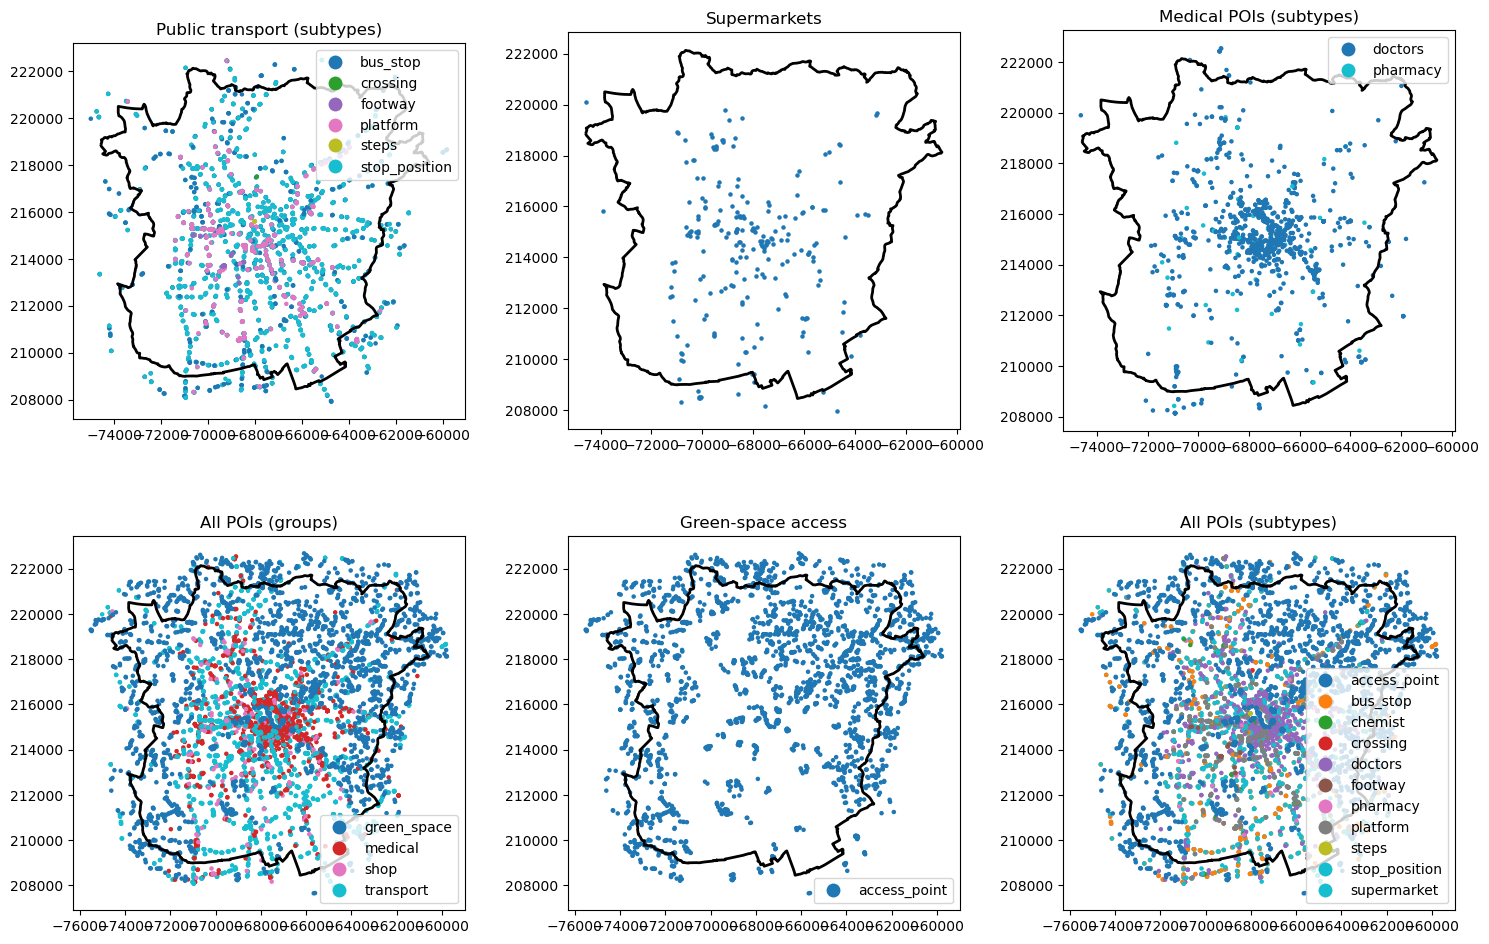

In [26]:
# Plots with poi_group and poi_subtype

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# 1) All public transport POIs by subtype (bus_stop, platform, tram_stop, station, halt)
ax1_1 = axs[0, 0]
mask_pt = pois_all_points["poi_group"] == "transport"
pois_all_points[mask_pt].plot(
    ax=ax1_1,
    column="poi_subtype",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax1_1, edgecolor="black", linewidth=2)
ax1_1.set_title("Public transport (subtypes)")

# 2) Shops by subtype (supermarket, chemist)
ax1_2 = axs[0, 1]
mask_shop = pois_all_points["poi_group"] == "shop"
pois_all_points[mask_shop].plot(
    ax=ax1_2,
    #column="poi_subtype",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax1_2, edgecolor="black", linewidth=2)
ax1_2.set_title("Supermarkets")

# 3) Medical POIs (doctors, hospital, clinic, pharmacy)
ax1_3 = axs[0, 2]
mask_med = pois_all_points["poi_group"] == "medical"
pois_all_points[mask_med].plot(
    ax=ax1_3,
    column="poi_subtype",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax1_3, edgecolor="black", linewidth=2)
ax1_3.set_title("Medical POIs (subtypes)")

# 4) All POIs by analysis group (transport / shop / doctor / pharmacy / green_space)
ax2_1 = axs[1, 0]
pois_all_points.plot(
    ax=ax2_1,
    column="poi_group",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax2_1, edgecolor="black", linewidth=2)
ax2_1.set_title("All POIs (groups)")

# 5) Green-space access points
ax2_2 = axs[1, 1]
mask_green = pois_all_points["poi_group"] == "green_space"
pois_all_points[mask_green].plot(
    ax=ax2_2,
    column="poi_subtype",   # e.g. 'access_point'
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax2_2, edgecolor="black", linewidth=2)
ax2_2.set_title("Green-space access")

# 6) Optional: all POIs again, but colored by subtype
ax2_3 = axs[1, 2]
pois_all_points.plot(
    ax=ax2_3,
    column="poi_subtype",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax2_3, edgecolor="black", linewidth=2)
ax2_3.set_title("All POIs (subtypes)")

plt.tight_layout()
plt.show()


Quick overview: Display number of features

In [27]:
# how many of each POI group
print("POI groups:")
print(pois_all_points["poi_group"].value_counts(dropna=False))

# how many of each POI subtype
print("\nPOI subtypes:")
print(pois_all_points["poi_subtype"].value_counts(dropna=False))

# how many of each POI analysis type
print("\nPOI analysis types:")
print(pois_all_points["analysis_type"].value_counts(dropna=False))

POI groups:
poi_group
transport      3217
green_space    2614
medical        1122
shop            227
Name: count, dtype: int64

POI subtypes:
poi_subtype
access_point     2614
stop_position    1455
bus_stop         1399
doctors          1053
platform          336
supermarket       183
pharmacy           69
chemist            44
footway            24
steps               2
crossing            1
Name: count, dtype: int64

POI analysis types:
analysis_type
public_transport    3217
green_space         2614
doctor              1053
shop                 227
pharmacy              69
Name: count, dtype: int64


##### Population of Graz (100m grid)

In [28]:
# open grid data set (population grid)
src = rasterio.open(POP_RAW_PATH)
print(src.crs)

# project Graz border into grid CRS (ESRI: 54009)
graz_geom = gdf_graz.to_crs(src.crs).geometry.iloc[0]

# mask grid with Graz geometry (pixels outside Graz are removed)
out_img, out_transform = mask(
    dataset=src,
    shapes=[graz_geom],
    crop=True
)

# copy metadata from the original grid and adjust metadata to the cropped grid
out_meta = src.meta.copy()
out_meta.update({
    "height": out_img.shape[1],
    "width":  out_img.shape[2],
    "transform": out_transform
})

# write and save a new grid
with rasterio.open(POP_GRAZ_PATH, "w", **out_meta) as dst:
    dst.write(out_img)

ESRI:54009


Load cropped Graz population grid

In [ ]:
with rasterio.open(POP_GRAZ_PATH) as dataset:
    graz_pop = dataset.read(1)

Quick overview of Graz population grid

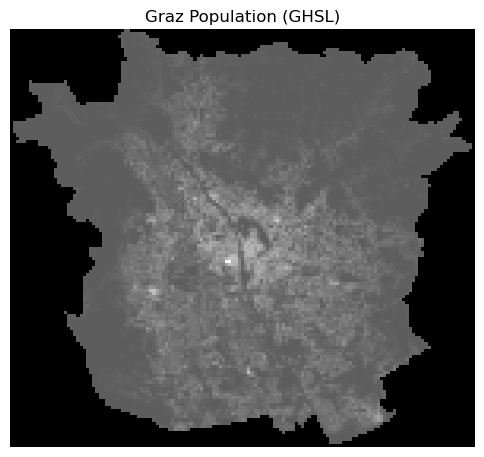

In [30]:
plt.figure(figsize=(6, 6))
plt.imshow(graz_pop, cmap="gray")
plt.title("Graz Population (GHSL)")
plt.axis("off")
plt.show()

##### Buildings of Graz

In [31]:
# load buildings of Graz
gdf_buildings = ox.features_from_place(
    place_name,
    tags={"building": True}
)
gdf_buildings = gdf_buildings.to_crs(epsg=31256)

# Save buildings as GeoParquet
gdf_buildings.to_parquet(BUILDINGS_PATH, index=False)
gdf_buildings = gpd.read_parquet(BUILDINGS_PATH)

# Delete point geometries
gdf_buildings = gdf_buildings[gdf_buildings.geometry.type.isin(["Polygon", "MultiPolygon"])]
gdf_buildings = gdf_buildings.to_crs(epsg=31256)


Quick overview map: Plot buildings of Graz

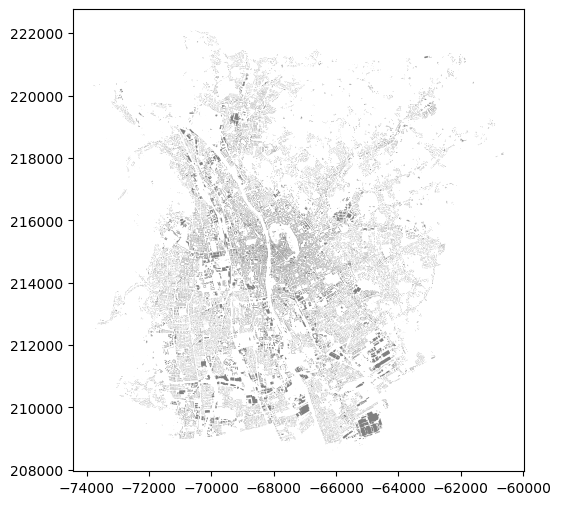

In [32]:
# all building data of Graz
fig, ax = plt.subplots(figsize=(6, 6))
gdf_buildings.plot(ax=ax, color="grey", linewidth=0)
plt.show()

##### Residential areas of Graz

In [33]:
# get residential areas of Graz
gdf_residential_raw = ox.features_from_place(place_name, tags={"landuse": "residential"})
gdf_residential = gdf_residential_raw.to_crs(epsg=31256)

gdf_residential = gdf_residential.dissolve()

gdf_residential = gpd.overlay(gdf_residential, gdf_graz, how='intersection')

# Save residential areas as GeoParquet
gdf_residential.to_parquet(RESIDENTIAL_PATH, index=False) 
gdf_residential = gpd.read_parquet(RESIDENTIAL_PATH)
gdf_residential = gdf_residential.to_crs(epsg=project_crs)

c:\Users\fzaar\miniconda3\envs\GIS2\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 253 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


Quick overview map: Plot residential areas of Graz

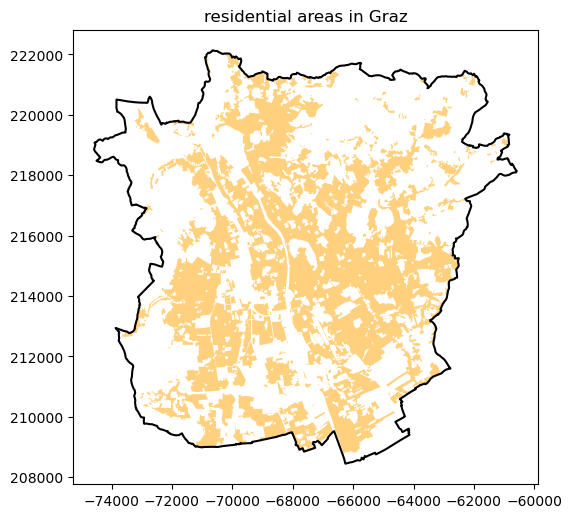

In [34]:
ax = gdf_graz.boundary.plot(edgecolor="black", figsize=(6, 6))

gdf_residential.plot(
    ax=ax,
    color="orange",
    alpha=0.5
)

plt.title("residential areas in Graz")
plt.show()

### Network analysis: 15-minute walking distance analysis

##### Routing with cutoff 1km to find distances <1km between all nodes in the network

In [35]:
MAX_DIST = 1000  # maximum walking distance in meters

# distances_from_node: dict[node_id] -> {other_node_id: distance_m}
distances_from_node = {}

for source in network_graz.nodes:
    lengths = nx.single_source_dijkstra_path_length(
        network_graz,
        source=source,
        weight="length",
        cutoff=MAX_DIST,
    )
    distances_from_node[source] = lengths


##### Find distances to POIs

In [36]:
# Only keep POIs that have a nearest_node
pois_routable = pois_all_points[pois_all_points["nearest_node"].notna()].copy()

# group by node and subtype
poi_by_node_and_type = (
    pois_routable.groupby(["nearest_node", "analysis_type"])
    .size()
    .rename("poi_count")
    .reset_index()
)
print(poi_by_node_and_type.head())

   nearest_node     analysis_type  poi_count
0      20832703  public_transport          1
1      20832756  public_transport          1
2      20832762  public_transport          2
3      20832809  public_transport          3
4      20832941            doctor          1


In [37]:
# Create easier lookup
node_to_types = defaultdict(set)
for row in poi_by_node_and_type.itertuples(index=False):
    node_to_types[row.nearest_node].add(row.analysis_type)


##### Find reachable POI types within 1km

In [38]:
node_coverage = {}  # node_id -> set of reachable analysis_type within 1km

for source, lengths in distances_from_node.items():
    reachable_types = set()
    for target_node in lengths.keys():
        if target_node in node_to_types:
            reachable_types |= node_to_types[target_node]
    node_coverage[source] = reachable_types

In [39]:
# Use nodes from network graph for saving the analysis
nodes_analysis, edges_analysis = ox.graph_to_gdfs(network_graz, nodes=True, edges=True)

In [40]:
# Find reachable types
nodes_analysis["reachable_types"] = nodes_analysis.index.map(
    lambda n: node_coverage.get(n, set())
)

In [42]:
# Assign POI types required within 1km here
required_types = {
    "shop",
    "public_transport",
    "green_space",
    "pharmacy",
    "doctor"
}

# Column indicating for each node if all required types are reachable within 1 km (Boolean)
nodes_analysis["has_all_required"] = nodes_analysis["reachable_types"].apply(
    lambda s: required_types.issubset(s)
)


In [43]:
# New df with only nodes within residential areas
nodes_analysis_residential = gpd.clip(nodes_analysis, gdf_residential).copy()

Text(0.5, 1.0, 'Nodes in residential areas with all POIs within 1 km')

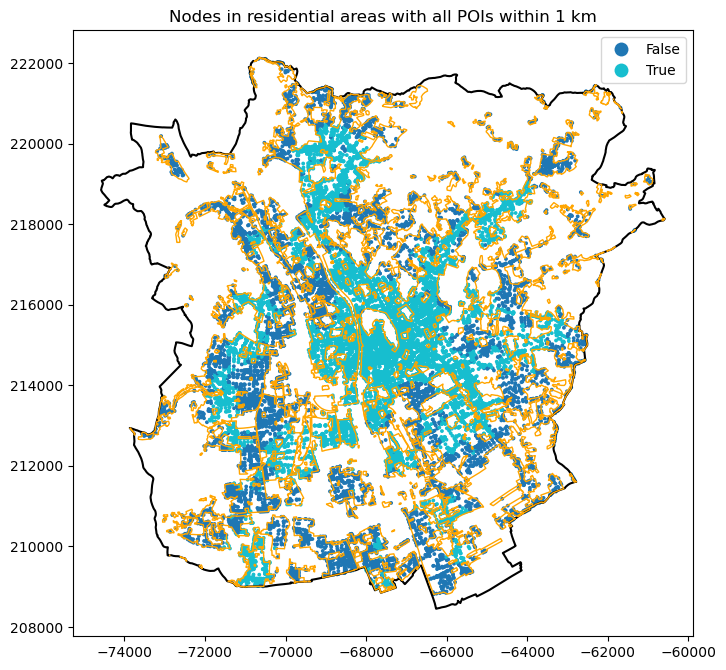

In [44]:
# Plot nodes in residential areas by whether they have all required POI types within 1 km

ax = gdf_graz.boundary.plot(edgecolor="black", figsize=(8, 8))
# plot gdf_residential boundary
gdf_residential.boundary.plot(ax=ax, edgecolor="orange", linewidth=1)

nodes_analysis_residential.plot(
    ax=ax,
    column="has_all_required",
    categorical=True,
    legend=True,
    markersize=3,
)

ax.set_title("Nodes in residential areas with all POIs within 1 km")

In [45]:
# Prepare extent and grid
minx, miny, maxx, maxy = gdf_graz.total_bounds

resolution = 50  # grid cell resolution in meters; lower values have longer computation time
x_coords = np.arange(minx, maxx, resolution)
y_coords = np.arange(miny, maxy, resolution)
xx, yy = np.meshgrid(x_coords, y_coords)

# Prepare node points and boolean values
# nodes: GeoDataFrame of network nodes with column 'has_all_required'
node_points = np.array([[p.x, p.y] for p in nodes.geometry])
node_access = nodes_analysis["has_all_required"].astype(float).values  # True->1.0, False->0.0

# Interpolate boolean (via nearest neighbour) onto grid
print("Interpolating has_all_required across grid using nearest neighbor...")
grid_access_float = griddata(
    node_points,
    node_access,
    (xx, yy),
    method="nearest"
)

# Convert back to boolean (NaN -> False)
grid_access_bool = ~np.isnan(grid_access_float) & (grid_access_float >= 0.5)

# Create grid polygons within Graz, attach boolean
print("Creating grid cells...")
grid_polygons = []

graz_geom = gdf_graz.geometry.iloc[0]

for i in range(len(x_coords) - 1):
    for j in range(len(y_coords) - 1):
        cell = Polygon([
            (x_coords[i],   y_coords[j]),
            (x_coords[i+1], y_coords[j]),
            (x_coords[i+1], y_coords[j+1]),
            (x_coords[i],   y_coords[j+1]),
        ])

        if not graz_geom.intersects(cell):
            continue

        clipped_cell = cell.intersection(graz_geom)
        if clipped_cell.is_empty or clipped_cell.area < 1:
            continue

        served = bool(grid_access_bool[j, i])

        grid_polygons.append({
            "served": served,            # True = within 15 min of all required services
            "geometry": clipped_cell
        })

grid_gdf = gpd.GeoDataFrame(grid_polygons, crs=nodes.crs)
print(f"Created {len(grid_gdf)} grid cells within Graz")

# Area statistics
grid_gdf["area_m2"] = grid_gdf.geometry.area
area_served = grid_gdf.loc[grid_gdf["served"], "area_m2"].sum()
area_total  = grid_gdf["area_m2"].sum()
share_area  = area_served / area_total
print("Share of area within 15 min of all services:", share_area)


Interpolating has_all_required across grid using nearest neighbor...
Creating grid cells...
Created 51827 grid cells within Graz
Share of area within 15 min of all services: 0.26238512131427705


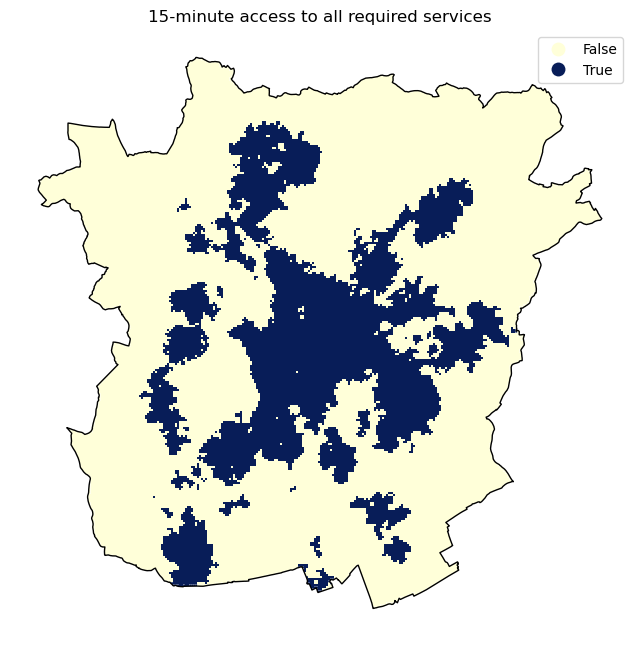

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot grid, colored by served True/False
grid_gdf.plot(
    column="served",
    categorical=True,
    cmap="YlGnBu",       # blue = served, yellow = not
    legend=True,
    ax=ax,
    edgecolor="none"   
)

# Overlay Graz boundary
gdf_graz.boundary.plot(ax=ax, color="black", linewidth=1)

ax.set_title("15-minute access to all required services")
ax.set_axis_off()
plt.show()


### Analysis: Population and area within the 15-minute-city

In [66]:
def pop_disaggregation(pop_grid, reachable_area):
    """
    This function takes raster data containing population data and overlays polygon data to which the population data should be disaggregated to.
    :param pop_grid: raster containing population data
    :param reachable_area: area within the criteria of a 15-minute-city
    """
    with rasterio.open(pop_grid) as src:
        data = src.read(1)
        transform = src.transform
        nodata = src.nodata
        masked = np.ma.masked_equal(data, nodata)
        crs = src.crs
        total_population = masked.sum()
    
    if reachable_area.crs != crs:
        reachable_area = reachable_area.to_crs(crs)
    
    union_geom = reachable_area.loc[reachable_area["served"]].geometry.union_all()

    rows, cols = data.shape
    cell_area = abs(transform.a * transform.e)

    pop_within = 0.0
    
    for row in range(rows):
        for col in range(cols):
            value = data[row, col]
            if value == nodata or np.isnan(value):
                continue
            x1, y1 = rasterio.transform.xy(transform, row, col, offset="ul")
            x2, y2 = rasterio.transform.xy(transform, row, col, offset="lr")
            cell = box(x1, y2, x2, y1)
            if not cell.intersects(union_geom):
                continue
            clipped = cell.intersection(union_geom)
            if clipped.is_empty:
                continue
            weight = clipped.area / cell_area
            pop_within += value * weight

    pop_within_share = pop_within / total_population
    
    return round(pop_within), pop_within_share

In [67]:
pop_graz_15min_city, share_pop_15min_city = pop_disaggregation(POP_GRAZ_PATH, grid_gdf)
print(pop_graz_15min_city)
print(share_pop_15min_city)

162425
0.5308871113125985


### Scenario: Add facility to areas with 4 of 5 POIs covered

In [41]:
# Add per-category coverage boolean columns
nodes_analysis_residential["covered_shop"] = nodes_analysis_residential["reachable_types"].apply(
    lambda s: "shop" in s
)
nodes_analysis_residential["covered_public_transport"] = nodes_analysis_residential["reachable_types"].apply(
    lambda s: "public_transport" in s
)
nodes_analysis_residential["covered_green_space"] = nodes_analysis_residential["reachable_types"].apply(
    lambda s: "green_space" in s
)
nodes_analysis_residential["covered_doctor"] = nodes_analysis_residential["reachable_types"].apply(
    lambda s: "doctor" in s
)
nodes_analysis_residential["covered_pharmacy"] = nodes_analysis_residential["reachable_types"].apply(
    lambda s: "pharmacy" in s
)

# number of covered categories
nodes_analysis_residential["num_covered"] = (
    nodes_analysis_residential["covered_shop"].astype(int)
    + nodes_analysis_residential["covered_public_transport"].astype(int)
    + nodes_analysis_residential["covered_green_space"].astype(int)
    + nodes_analysis_residential["covered_doctor"].astype(int)
    + nodes_analysis_residential["covered_pharmacy"].astype(int)
)

# consistency with has_all_required
# nodes_analysis["has_all_required"] = nodes_analysis["num_covered"].eq(5)


In [42]:
# Save nodes with exactly 4 of 5 covered
nodes_analysis_residential = nodes_analysis_residential[nodes_analysis_residential["num_covered"] == 4].copy()
nodes_analysis_residential["missing_type"] = nodes_analysis_residential["reachable_types"].apply(
    lambda s: list(required_types - s)[0]
)

In [43]:
print(nodes_analysis_residential.head())

                        y             x  street_count highway railway  \
osmid                                                                   
2472218013  209815.473585 -68111.652245             1     NaN     NaN   
35469011    209640.684462 -67612.070888             3     NaN     NaN   
2471031639  209655.762371 -67615.092319             3     NaN     NaN   
2471032014  209951.053897 -67577.434150             1     NaN     NaN   
2471032050  209963.460887 -67581.215828             3     NaN     NaN   

           junction  ref                       geometry  \
osmid                                                     
2472218013      NaN  NaN  POINT (-68111.652 209815.474)   
35469011        NaN  NaN  POINT (-67612.071 209640.684)   
2471031639      NaN  NaN  POINT (-67615.092 209655.762)   
2471032014      NaN  NaN  POINT (-67577.434 209951.054)   
2471032050      NaN  NaN  POINT (-67581.216 209963.461)   

                                          reachable_types  has_all_require

Text(0.5, 1.0, 'Nodes with 4 of 5 POIs within 1 km')

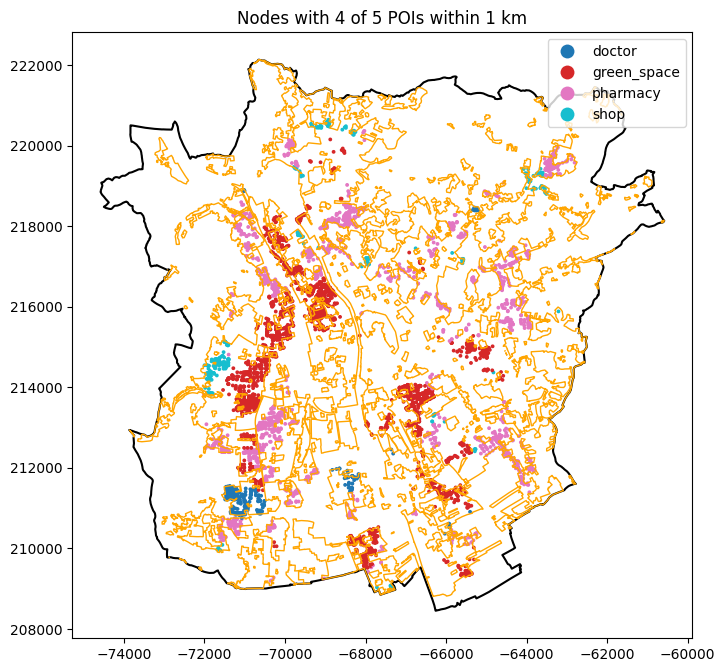

In [44]:
ax = gdf_graz.boundary.plot(edgecolor="black", figsize=(8, 8))
gdf_residential.boundary.plot(ax=ax, edgecolor="orange", linewidth=1)
nodes_analysis_residential.plot(
    ax=ax,
    column="missing_type",
    categorical=True,
    legend=True,
    markersize=3,
)

ax.set_title("Nodes with 4 of 5 POIs within 1 km")


In [45]:
print(poi_by_node_and_type.head())
print("rows poi_by_node_and_type:", len(poi_by_node_and_type))

print("node_to_types length:", len(node_to_types))
example_node = next(iter(node_to_types.keys()))
print("example node_to_types entry:", example_node, node_to_types[example_node])

   nearest_node     analysis_type  poi_count
0      20832703  public_transport          1
1      20832756  public_transport          1
2      20832762  public_transport          2
3      20832809  public_transport          3
4      20832941            doctor          1
rows poi_by_node_and_type: 4523
node_to_types length: 4409
example node_to_types entry: 20832703 {'public_transport'}


##### Cluster nodes with one missing POI with DBSCAN

In [46]:
# Split nodes by missing type

types = nodes_analysis_residential["missing_type"].unique()

clusters_per_type = {}
for t in types:
    subset = nodes_analysis_residential[nodes_analysis_residential["missing_type"] == t].copy()
    clusters_per_type[t] = subset

In [ ]:
# Spatial clustering with DBSCAN

eps = 400  # radius of the neighborhood in meters
min_samples = 50  # minimum nr. of nodes to form a cluster, adjust this for different results!!

for t, g in clusters_per_type.items():
    coords = np.vstack([g.geometry.x.values, g.geometry.y.values]).T  # Create coordinate stack for DBSCAN

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(coords)   # -1 = noise

    clusters_per_type[t]["cluster_id"] = labels  # which local cluster each node belongs to

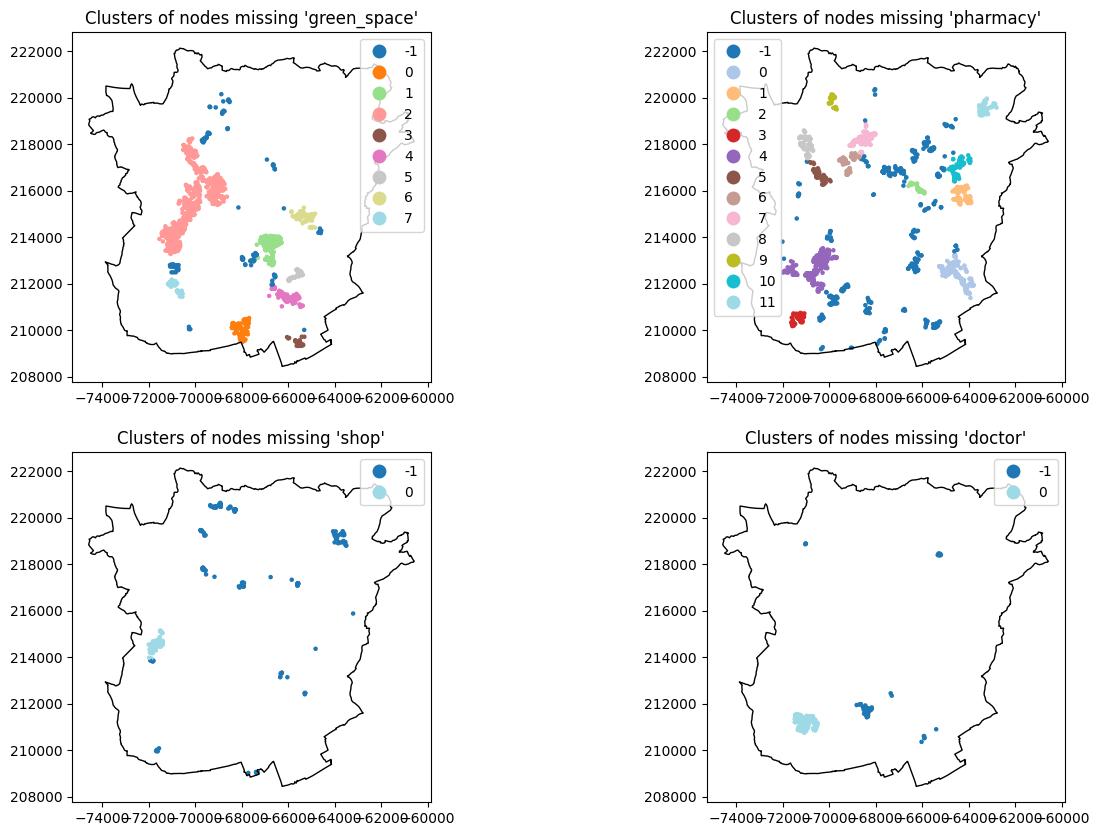

In [48]:
# Plot clusters for each missing type
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, (t, g) in enumerate(clusters_per_type.items()):
    ax = axs[i // 2, i % 2]
    gdf_graz.boundary.plot(ax=ax, edgecolor="black", linewidth=1)

    g.plot(
        ax=ax,
        column="cluster_id",
        categorical=True,
        legend=True,
        markersize=5,
        cmap="tab20"
    )

    ax.set_title(f"Clusters of nodes missing '{t}'")

In [49]:
candidate_sites = []

for t, g in clusters_per_type.items():
    for cid, group in g[g["cluster_id"] != -1].groupby("cluster_id"):
        # centroid of cluster
        cx = group.geometry.x.mean()
        cy = group.geometry.y.mean()

        # choose node closest to centroid as candidate facility
        d2 = (group.geometry.x - cx)**2 + (group.geometry.y - cy)**2
        medoid_node = group.loc[d2.idxmin()]

        candidate_sites.append({
            "missing_type": t,
            "cluster_id": cid,
            "node_id": medoid_node.name,
            "geometry": medoid_node.geometry,
        })

candidates_gdf = gpd.GeoDataFrame(candidate_sites, crs=project_crs)

<Axes: >

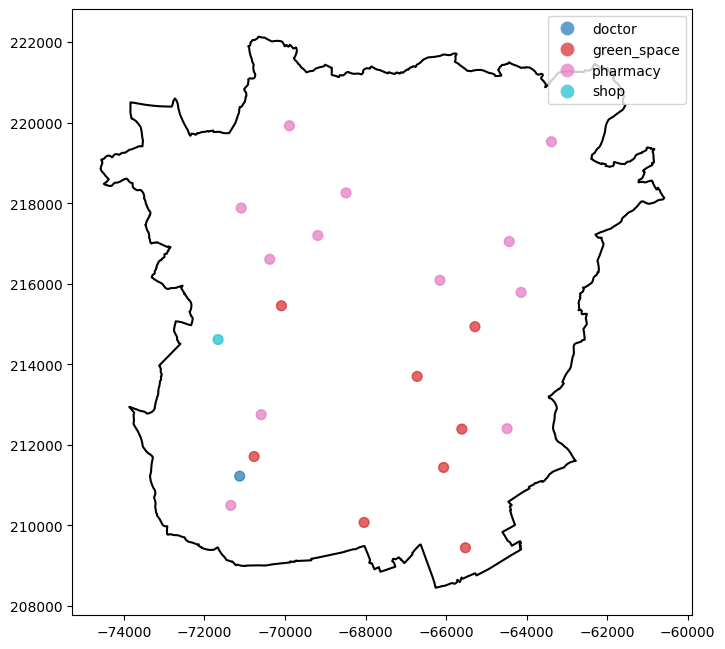

In [50]:
# Plot candidate sites
fig, ax = plt.subplots(figsize=(8, 8))
gdf_graz.boundary.plot(ax=ax, edgecolor="black")
candidates_gdf.plot(
    ax=ax,
    column="missing_type",
    categorical=True,
    legend=True,
    markersize=50,
    alpha=0.7,
)